<a href="https://colab.research.google.com/github/nakatoconstance/A-Complete-Course-on-Windows-Server-2016-Administration-/blob/master/AMR_TUNIS_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMR Tunis Data Processing Pipeline
This cell executes the full AMR data processing pipeline:
- Upload and robustly read multiple raw AST files (CSV/XLS/XLSX) with different encodings and delimiters.  
- Normalize headers and values (antibiotic names, patient metadata, MIC/ZONE/SIR).  
- Build a **long-format dataset** (one row per antibiotic measurement).  
- Refine the dataset:
  - Flag tested vs. untested results.  
  - Preserve culture-negatives (important for denominators).  
  - Collapse to one row per patient–date–specimen–organism–antibiotic.  
- standardise antibiotic variants.  
- Create **wide-format tables** (SIR, MIC, ZONE) for downstream analysis.  
- Generate QC summaries and export clean outputs in CSV and Excel.  

In [ ]:
#print un

In [ ]:
# === ONE-CELL: upload → robust read → normalize headers → detect MIC/ZONE/SIR → LONG
#           → refine + flags (TESTED) → preserve culture-negatives (4-key)
#           → collapse to ONE per (patient,date,specimen,organism,antibiotic)
#           → canonicalize → WIDE TABLES → QC → exports ======================
import io, re, sys, subprocess, importlib, unicodedata, math, hashlib
import numpy as np
import pandas as pd
from IPython.display import display
from google.colab import files

# ---------------- deps
def ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
        importlib.invalidate_caches()

ensure("openpyxl")                # .xlsx
ensure("xlrd>=2.0.1", "xlrd")     # .xls
ensure("chardet")
ensure("Unidecode", "unidecode")

import chardet
from unidecode import unidecode

print("👉 Select ALL your raw files at once (CSV/XLS/XLSX)...")
uploaded = files.upload()
if not uploaded:
    raise SystemExit("No files uploaded.")

# ---------------- helpers
_ARABIC_DIGITS = str.maketrans("٠١٢٣٤٥٦٧٨٩", "0123456789")

def detect_enc(b: bytes):
    res = chardet.detect(b)
    return (res.get("encoding") or "utf-8"), float(res.get("confidence") or 0.0)

def read_csv_robust(raw: bytes) -> pd.DataFrame:
    encs = ["utf-8-sig","utf-8","utf-16","utf-16le","utf-16be","cp1256","windows-1256","latin1","cp1252"]
    guess, _ = detect_enc(raw)
    if guess and guess.lower() not in [e.lower() for e in encs]:
        encs = [guess] + encs
    seps = [None, ",", ";", "\t", "|"]  # None = sniff
    for enc in encs:
        for sep in seps:
            try:
                return pd.read_csv(io.BytesIO(raw), encoding=enc, sep=sep, engine="python", on_bad_lines="skip")
            except Exception:
                pass
    return pd.read_csv(io.BytesIO(raw.decode("latin1", errors="ignore").encode("latin1")),
                       encoding="latin1", sep=None, engine="python", on_bad_lines="skip")

def norm_ascii(name: str) -> str:
    s = str(name)
    s = s.translate(_ARABIC_DIGITS)
    s = unicodedata.normalize("NFKC", s)
    s = unidecode(s)
    s = s.lower()
    s = re.sub(r"[^\w]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s or "col"

# --- Antibiotic patterns (broad). Add more if needed.
ABX_PATTERNS = {
    # === Penicillins ===
    "ampicillin": r"ampi(cillin|ciline|cilline|cilin)?",
    "amoxicillin": r"amoxi(cillin|cilline|cilin)?",
    "ticarcillin": r"ticar(cillin|cilline)?",
    "piperacillin": r"piper(a)?cillin(e)?",
    "oxacillin": r"oxa(cillin|cilline)",
    "penicillin_g": r"peni(cillin|cilline).*g|peni.*\bg\b|penicillin_g",

    # β-lactamase inhibitor combinations
    "tazobactam": r"tazo(bactam)?",  # usually part of piperacillin/tazobactam

    # === Cephalosporins (1st–4th gen) ===
    "cephalexin": r"cefa?lex(ine|in|ine_)?",     # 1st gen
    "cefoxitin": r"cefox?it(ine|in)",            # 2nd gen (cephamycin)
    "cefuroxime": r"cefur(oxime|ox|oxime)",      # 2nd gen
    "cefixime": r"cefix(ime)?",                  # 3rd gen (oral)
    "ceftazidime": r"ceftazi(dime|dim)",         # 3rd gen
    "cefotaxime": r"cefotaxi?me",                # 3rd gen
    "cefepime": r"cefep(ime)",                   # 4th gen

    # === Monobactam ===
    "aztreonam": r"aztreonam",

    # === Carbapenems ===
    "ertapenem": r"erta(penem|peneme)",
    "imipenem": r"imi(penem|peneme)",
    "meropenem": r"mero(penem|peneme)",

    # === Other β-lactams (not in CLSI, mostly EUCAST) ===
    "mecillinam": r"mecill?inam?",
    "temocillin": r"temocill?in(e)?",

    # === Quinolones/Fluoroquinolones ===
    "nalidixic_acid": r"(acid(e)?_?)?nalidix(i?que)?",   # screening agent
    "norfloxacin": r"norflox(acine|acin|acin(e)?)",
    "ofloxacin": r"oflox(acine|acin)",
    "pefloxacin": r"peflox(acine|acin)",
    "ciprofloxacin": r"cipro(floxacine|floxacin?)",
    "levofloxacin": r"levo(floxacine|floxacin?)",

    # === Aminoglycosides ===
    "gentamicin": r"genta(micin|micine)",
    "amikacin": r"amika?cin(e)?",
    "kanamycin": r"k(a|e)namy?cin(e)?",
    "tobramycin": r"tobra(mycin|mycine)",
    "netilmicin": r"netil(micin|micine)",
    "streptomycin": r"strep(to)?myc(in|ine|ine_hc|ine_300ug|ine_300)?",
    "spectinomycin": r"spectino(mycin|mycine)",

    # === Tetracyclines ===
    "tetracycline": r"tetra(cyclin|cycline)",
    "minocycline": r"mino(cyclin|cycline)",
    "tigecycline": r"tige(cyclin|cycline)",

    # === Macrolides & Lincosamides ===
    "erythromycin": r"erythro(mycin|mycine)",   # Macrolide
    "clindamycin": r"clinda(mycin|mycine)",     # Lincosamide
    "telithromycin": r"telithro(mycin|mycine)", # Ketolide

    # === Streptogramins & Others ===
    "pristinamycin": r"pristina(mycin|mycine)",  # Streptogramin
    "linezolid": r"linezolid(e)?",               # Oxazolidinone

    # === Glycopeptides ===
    "vancomycin": r"vancomy?cin(e)?",
    "teicoplanin": r"teico(planin|planine)",

    # === Rifamycins ===
    "rifampin": r"rifamp(in|icine|icin|icine)?",

    # === Phenicols ===
    "chloramphenicol": r"chlora?mphenicol",

    # === Folate pathway inhibitors ===
    "trimethoprim_sulfamethoxazole": r"tri?me?th(oprim|oprime).*sulfa(mide|mides)?",

    # === Others (various) ===
    "fosfomycin": r"fosfo(mycin|mycine)",
    "colistin": r"colistin(e)?",               # Polymyxin
    "nitrofurantoin": r"nitro(furantoin|furantoine)",
    "fusidic_acid": r"(acid(e)?_?)?fusi(dic|dique)",   # Steroid antibiotic
    "metronidazole": r"metro(nidazole|nidazol)?",      # Nitroimidazole
}
ABX_RE = {k: re.compile(v, re.I) for k, v in ABX_PATTERNS.items()}

def detect_antibiotic_from_text(text: str) -> str | None:
    t = norm_ascii(text)
    for canon, rx in ABX_RE.items():
        if rx.search(t):
            return canon
    return None

# disk potency in header (e.g., _10µg/_30µg/_5µg)
POT_RE = re.compile(r"(?:^|[ _-])(\d+(?:[.,]\d+)?)\s*(?:ug|µg|μg)\b", re.I)
def header_disk_potency(col_raw: str) -> float | None:
    m = POT_RE.search(str(col_raw).replace("μ", "µ"))
    if m:
        try:
            return float(m.group(1).replace(",", "."))
        except:
            return None
    return None

def classify_measure(col_raw: str, cell_value):
    """
    Returns: measure_type {"MIC","ZONE","SIR","UNKNOWN"}, unit {"mg/L","mm",""},
             sir in {"S","I","R",None}, num (float|None).
    """
    txt = "" if (cell_value is None or (isinstance(cell_value, float) and np.isnan(cell_value))) else str(cell_value).strip()
    txt_norm = unidecode(txt).translate(_ARABIC_DIGITS)
    txt_norm = re.sub(r"\s+", " ", txt_norm)

    if txt_norm == "":
        return "UNKNOWN", "", None, None

    # SIR detection (letters)
    if re.fullmatch(r"[SIR]", txt_norm, flags=re.I) or re.search(r"\b(SENSI|INTER|RESI)\b", txt_norm, flags=re.I):
        return "SIR", "", txt_norm[0].upper(), None

    is_mic_hdr = bool(re.search(r"\b(CMI|MIC)\b", str(col_raw), re.I))
    has_pot_hdr = header_disk_potency(str(col_raw)) is not None

    # numeric extraction (handles commas, inequality)
    m = re.search(r"^[<>]=?\s*([0-9]+(?:[.,][0-9]+)?)", txt_norm) or re.search(r"([0-9]+(?:[.,][0-9]+)?)", txt_norm)
    if m:
        val = float(m.group(1).replace(",", "."))
        if is_mic_hdr:
            return "MIC", "mg/L", None, val
        if has_pot_hdr:
            return "ZONE", "mm", None, val
        if 6 <= val <= 50 and float(val).is_integer():
            return "ZONE", "mm", None, val
        # fallback → likely MIC
        return "MIC", "mg/L", None, val

    return "UNKNOWN", "", None, None

# patient/sample metadata columns to keep if found
META_KEYS = {
    "patient_id": r"num(ero|éro|èro|ero)?.*patient|رقم.*مريض",
    "sex": r"\b(sexe|جنس)\b",
    "birth_date": r"(naissance| ميلاد|ولادة)",
    "admission_date": r"(hospitali|admission|hospitalisation|استشف|ادخال|دخول|قبول|تنوم)",
    "service": r"(service|قسم|خدمة|مصلحة)",
    "request_id": r"(num(ero|éro|èro|ero)?.*demande|رقم.*طلب|طلب)",
    "collection_date": r"(pr[ée]l[èe]vement.*date|date.*pr[ée]l[èe]vement|تاريخ.*(عينة|سحب|اخذ)|(?:اخذ|سحب).*تاريخ)",
    "specimen_type": r"(type.*pr[ée]l[èe]vement|نوع.*(عينة|مسحة))",
    "specimen_source": r"(orig?ine|مصدر|اصل|موضع|مكان)",
    "organism": r"(germe|جرثوم|ميكروب|بكتير)",
}
META_RE = {k: re.compile(v, re.I) for k, v in META_KEYS.items()}

def map_meta_columns(cols_raw: list[str]) -> dict:
    mapping = {}
    for c in cols_raw:
        raw = str(c); norm = norm_ascii(raw)
        for k, rx in META_RE.items():
            if rx.search(raw) or rx.search(norm):
                mapping.setdefault(k, c)
    return mapping

# ---------------- read all files/sheets, build long
long_rows = []
for fname, raw in uploaded.items():
    low = fname.lower()
    try:
        if low.endswith(".csv"):
            df0 = read_csv_robust(raw); sheets = [(None, df0)]
        elif low.endswith(".xlsx"):
            xl = pd.ExcelFile(io.BytesIO(raw), engine="openpyxl")
            sheets = [(sh, xl.parse(sh)) for sh in xl.sheet_names]
        elif low.endswith(".xls"):
            xl = pd.ExcelFile(io.BytesIO(raw), engine="xlrd")
            sheets = [(sh, xl.parse(sh)) for sh in xl.sheet_names]
        else:
            print(f"⚠️ Skipping unsupported: {fname}")
            continue
    except Exception as e:
        print(f"❌ Failed to open {fname}: {e}")
        continue

    for sh, df in sheets:
        original_cols = list(df.columns)

        # antibiotic-like columns
        abx_cols = []
        for c in original_cols:
            canon = detect_antibiotic_from_text(str(c))
            if canon:
                abx_cols.append((c, canon))
        if not abx_cols:
            continue

        meta_map = map_meta_columns(original_cols)

        for _, row in df.iterrows():
            for col_raw, abx in abx_cols:
                val = row.get(col_raw)
                mtype, unit, sir, num = classify_measure(col_raw, val)
                disk = header_disk_potency(str(col_raw))
                out = {
                    "_source_file": fname,
                    "_source_sheet": sh or "",
                    "antibiotic": abx,
                    "source_col": str(col_raw),
                    "measure_type": mtype,
                    "unit": unit,
                    "disk_potency_ug": disk,
                    "value_raw": None if pd.isna(val) else str(val),
                    "value_num": num,
                    "sir": sir,
                }
                for mk, src in meta_map.items():
                    out[mk] = row.get(src)
                long_rows.append(out)

long_df = pd.DataFrame(long_rows)

# normalize dates & sex
for dcol in ["birth_date", "admission_date", "collection_date"]:
    if dcol in long_df.columns:
        long_df[dcol] = pd.to_datetime(long_df[dcol], errors="coerce").dt.date

if "sex" in long_df.columns:
    def _sx(x):
        if pd.isna(x): return x
        s = str(x).strip().lower()
        if s.startswith(("m","h")) or "masc" in s or "ذكر" in s: return "M"
        if s.startswith(("f",)) or "fem" in s or "أنث" in s: return "F"
        return np.nan
    long_df["sex"] = long_df["sex"].apply(_sx)

# order columns
front = ["_source_file","_source_sheet","antibiotic","source_col","measure_type","unit","disk_potency_ug","value_raw","value_num","sir"]
meta_cols = [c for c in ["patient_id","sex","birth_date","admission_date","service","request_id","collection_date","specimen_type","specimen_source","organism"] if c in long_df.columns]
cols = front + meta_cols + [c for c in long_df.columns if c not in front + meta_cols]
long_df = long_df[cols]

# save raw-long and preview
out_long = "antibiotic_long.csv"
long_df.to_csv(out_long, index=False, encoding="utf-8")
print(f"✅ Created {out_long}  |  shape={long_df.shape}")
#display(long_df.head(12))

# =================== SECOND PASS: refine, FLAGS, and COLLAPSE ===================
df = pd.read_csv(out_long, dtype=str).fillna("")
df["value_num"] = pd.to_numeric(df["value_raw"].str.replace(",","."), errors="coerce")
df["sir_norm"] = df["sir"].str.strip().str.upper()
df["has_sir"] = df["sir_norm"].isin(["S","I","R"])
df["tested"]  = df["has_sir"] | df["value_num"].notna()   # <<<<< KEY: real performed test

# normalize the 5-key fields to avoid hidden dupes (spaces/case)
df["patient_id"]      = df["patient_id"].astype(str).str.strip()
df["collection_date"] = pd.to_datetime(df["collection_date"], errors="coerce").dt.strftime("%Y-%m-%d")
df["specimen_type"]   = df["specimen_type"].astype(str).str.strip().str.upper()
df["organism"]        = df["organism"].fillna("").astype(str).str.strip().str.upper()
df["antibiotic"]      = df["antibiotic"].astype(str).str.strip().str.lower()

# === ORGANISM CANONICALIZATION & GROUPING ===============================
# === ORGANISM CANONICALIZATION v2 (ssp/subsp + CONS + spp + typos) ======
import re
from unidecode import unidecode

# keep a copy for audit (optional)
_org_raw_before = df["organism"].copy()

def _norm_upper(s: str) -> str:
    s = unidecode(str(s or "")).strip()
    s = re.sub(r"\s+", " ", s)            # collapse spaces
    return s.upper()

def _collapse_subspecies(u: str) -> str:
    # normalize SSP/SUBSP tokens (any case, with/without dot)
    u = re.sub(r"\bS(?:UB)?SP\.?\b", "SUBSP", u, flags=re.I)
    # reduce "Genus Species SUBSP Whatever" -> "Genus Species"
    m = re.match(r"^([A-Z]+)\s+([A-Z]+)\s+SUBSP\b", u, flags=re.I)
    if m:
        return f"{m.group(1)} {m.group(2)}"
    return u

# exact uppercase → canonical Title-case (seed)
seed_map = {
    "ENTEROCOCCUS FAECIUM": "Enterococcus faecium",
    "ENTEROCOCCUS FAECALIS": "Enterococcus faecalis",
    "STAPHYLOCOCCUS AUREUS": "Staphylococcus aureus",
    "STAPHYLOCOCCUS EPIDERMIDIS": "Staphylococcus epidermidis",
    "PSEUDOMONAS AERUGINOSA": "Pseudomonas aeruginosa",
    "ACINETOBACTER BAUMANNII": "Acinetobacter baumannii",
    "KLEBSIELLA PNEUMONIAE": "Klebsiella pneumoniae",
    "PROTEUS MIRABILIS": "Proteus mirabilis",
    "HAEMOPHILUS INFLUENZAE": "Haemophilus influenzae",
    "ENTEROBACTER CLOACAE": "Enterobacter cloacae complex",
    "ESCHERICHIA COLI": "Escherichia coli",
    "STREPTOCOCCUS PNEUMONIAE": "Streptococcus pneumoniae",
    "CANDIDA ALBICANS": "Candida albicans",
    "CRONOBACTER SAKAZAKII": "Cronobacter sakazakii",  # typo fix

    # CONS (group label)
    "STAPHYLOCOCCUS COAGULASE -": "Coagulase-negative staphylococci",
    "STAPHYLOCOCCUS COAGULASE NEGATIF": "Coagulase-negative staphylococci",
    "STAPHYLOCOQUES A COAGULASE NEGATIVE": "Coagulase-negative staphylococci",
}

def _apply_seed_or_pass(u: str) -> str:
    return seed_map.get(u, u)

def _fix_cons(u: str) -> str:
    # any “STAPHYLOCOCCUS ... COAGULASE ... NEGAT...” -> CONS
    if "STAPHYLOCOCCUS" in u and "COAGULASE" in u and ("NEGAT" in u or "-" in u):
        return "COAGULASE-NEGATIVE STAPHYLOCOCCI"
    return u

def _standardize_spp_or_title(u: str) -> str:
    # unify Genus sp/SP/SPP/species -> "Genus spp."
    if re.search(r"\b(SP|SPP|SPECIES)\.?\b$", u, flags=re.I):
        base = re.sub(r"\b(SP|SPP|SPECIES)\.?\b$", "", u, flags=re.I).strip()
        return (base.title() + " spp.").strip()
    return u.title()

def canonicalize_org(x: str) -> str:
    u = _norm_upper(x)
    u = _collapse_subspecies(u)
    u = _fix_cons(u)
    u = _apply_seed_or_pass(u)  # applies only if exact match in seed
    # cleanup known “identification pending” French labels (optional)
    u = re.sub(r"ENT[ÉE]ROBACT[ÉE]RIE EN COURS D[’']IDENTIFICATION", "ENTEROBACTERALES – IDENTIFICATION PENDING", u)
    u = re.sub(r"BACILLE A GRAM NEGATIF EN COURS D[’']IDENTIFICATION", "GRAM-NEGATIVE BACILLUS – IDENTIFICATION PENDING", u)
    # final standardization (spp + title-case)
    return _standardize_spp_or_title(u)

df["organism"] = df["organism"].map(canonicalize_org)

# organism group (simple, coverage-focused)
def _org_group(canon: str) -> str:
    u = str(canon).upper()
    if not u: return "UNKNOWN"
    if "COAGULASE-NEGATIVE STAPHYLOCOCCI" in u: return "Gram-positive cocci"
    if u.startswith(("STAPHYLOCOCCUS","STREPTOCOCCUS","ENTEROCOCCUS")): return "Gram-positive cocci"
    if u.startswith(("ESCHERICHIA","KLEBSIELLA","PSEUDOMONAS","ACINETOBACTER",
                     "ENTEROBACTER","PROTEUS","SALMONELLA","HAEMOPHILUS",
                     "CITROBACTER","SERRATIA","MORGANELLA","CRONOBACTER","LECLERCIA","RAOULTELLA","BURKHOLDERIA")):
        return "Gram-negative bacilli"
    if u.startswith("CANDIDA") or "YEAST" in u: return "Yeast/Fungus"
    if u.endswith("SPP.") or u.endswith("SPECIES"): return "UNKNOWN"
    return "UNKNOWN"

df["org_group"] = df["organism"].map(_org_group)
# ======================================================================

# (Optional) Quick audit to confirm collapses worked
_dupes = (
    pd.DataFrame({"raw": _org_raw_before, "canon": df["organism"]})
      .value_counts().reset_index(name="n")
      .groupby("canon", as_index=False)
      .agg(total=("n","sum"), raw_variants=("raw", lambda s: sorted(set(s))))
      .query("raw_variants.str.len() > 1", engine="python")
      .sort_values("total", ascending=False)
)
print("🔎 Raw→Canonical buckets with multiple raw variants (top 20):")
print(_dupes.head(20).to_string(index=False))

# (Optional) Show top organisms after canonicalization
print("\n📊 Top organisms after canonicalization:")
print(df["organism"].value_counts().head(25))

# =======================================================================


# ---------------- PRESERVE CULTURE-NEGATIVES at 4-key; drop header-only for positives
REAL = ["SIR","MIC","ZONE"]  # used only for reporting; 'tested' drives logic
grp4 = ["patient_id","collection_date","specimen_type","organism"]
has_tested_map = (
    df.groupby(grp4)["tested"].apply(lambda s: bool(s.max()))
      .rename("grp_has_tested")
      .reset_index()
)
df = df.merge(has_tested_map, on=grp4, how="left")

# Keep all tested rows for groups that have any; for groups without tested rows, keep 1 representative row
keep_tested_rows = df[df["tested"]].copy()
neg_groups = df[~df["grp_has_tested"]].copy()
neg_rep = (
    neg_groups.sort_values(grp4 + ["antibiotic", "source_col"])
              .drop_duplicates(subset=grp4, keep="first")
)
df = pd.concat([keep_tested_rows, neg_rep], ignore_index=True)
df.drop(columns=["grp_has_tested"], inplace=True)
print(f"🧯 Preserved {len(neg_rep)} culture-negative (patient,date,specimen,organism) groups; kept only real tests for positives.")

# ---------------- FINAL COLLAPSE to ONE per (patient,date,specimen,organism,antibiotic)
five_key = ["patient_id","collection_date","specimen_type","organism","antibiotic"]

# Drop UNTESTED rows when a tested row exists in the same 5-key
grp_has_tested5 = df.groupby(five_key)["tested"].transform("max").astype(bool)
df = df.loc[~((~df["tested"]) & grp_has_tested5)].copy()

# If multiple tested rows remain, choose best: SIR > MIC (smallest) > ZONE (largest)
prio_map5 = {"SIR": 3, "MIC": 2, "ZONE": 1}
df["_prio5"] = df["measure_type"].map(prio_map5).fillna(0)
def _tie5(row):
    vn = row["value_num"]
    if row["measure_type"]=="MIC" and not pd.isna(vn):  return float(vn)     # smaller better
    if row["measure_type"]=="ZONE" and not pd.isna(vn): return -float(vn)    # larger better
    return 0.0
df["_tie5"] = df.apply(_tie5, axis=1)
#df = df.sort_values(five_key + ["_prio5","_tie5"], ascending=[True,True,True,True,True,False])
df = df.sort_values(
    five_key + ["_prio5","_tie5"],
    ascending=[True]*len(five_key) + [False, True],  # 5 + 2 = 7 flags
    kind="mergesort",
)

before_collapse = len(df)
df = df.drop_duplicates(subset=five_key, keep="first").copy()
after_collapse  = len(df)
df.drop(columns=["_prio5","_tie5","sir_norm","has_sir"], inplace=True, errors="ignore")
print(f"🔂 Collapsed per (patient,date,specimen,organism,antibiotic): {before_collapse} → {after_collapse}")

# ---------------- Canonicalize antibiotic variants (optional combos)
df["antibiotic_canon"] = df["antibiotic"].astype(str)
_abx_map = {
    r"\bamoxicilline\s*\+\s*ac\.?\s*clavulanique\b": "amoxicilline_clavulanique",
    r"\bticarcilline\s*\+\s*ac\.?\s*clavulanique\b": "ticarcilline_clavulanique",
    r"\bpiperacilline\s*\+\s*tazobactam\b": "piperacilline_tazobactam",
}
for pat, repl in _abx_map.items():
    df.loc[df["antibiotic_canon"].str.contains(pat, case=False, regex=True), "antibiotic_canon"] = repl

# ---------------- WIDE TABLES (specimen–organism rows)
# Build a specimen id for wide tables
spec_keys = [k for k in ["request_id","patient_id","collection_date","specimen_type","specimen_source"] if k in df.columns]
if spec_keys:
    df["_specimen_id"] = df[spec_keys].astype(str).agg("|".join, axis=1)
else:
    base = (df.get("patient_id","") + "|" + df.get("collection_date","") + "|" + df.get("specimen_type",""))
    df["_specimen_id"] = base.astype(str).apply(lambda s: hashlib.md5(s.encode()).hexdigest()[:10])

group_keys = [k for k in ["_specimen_id","organism"] if k in df.columns]
if len(group_keys) < 2:
    raise SystemExit("Need _specimen_id and organism to build wide tables.")

prio_map = {"SIR": 3, "MIC": 2, "ZONE": 1}
def pick_best_rows(g):
    g2 = g.copy()
    g2["_prio"] = g2["measure_type"].map(prio_map).fillna(0)
    _vn = pd.to_numeric(g2.get("value_num",""), errors="coerce")
    tie = np.where(g2["measure_type"].eq("MIC"), _vn, np.where(g2["measure_type"].eq("ZONE"), -_vn, 0.0))
    g2["_tie"] = tie
    g2 = g2.sort_values(by=["_prio","_tie"], ascending=[False, True])
    return g2.head(1)

abx_key = "antibiotic_canon" if "antibiotic_canon" in df.columns else "antibiotic"
best = (
    df[df["tested"]]  # only tested for wides
      .groupby(group_keys + [abx_key], as_index=False, sort=False)
      .apply(lambda g: pick_best_rows(g))
      .reset_index(drop=True)
)

# A) SIR wide (letters)
sir_best = best[best["measure_type"]=="SIR"][group_keys + [abx_key, "sir"]].copy()
if not sir_best.empty:
    sir_wide = sir_best.pivot_table(index=group_keys, columns=abx_key, values="sir", aggfunc="first").reset_index()
    sir_wide.columns.name = None
else:
    sir_wide = pd.DataFrame(columns=group_keys)

# B) MIC wide (numeric, mg/L)
mic_best = best[best["measure_type"]=="MIC"][group_keys + [abx_key, "value_num"]].copy()
if not mic_best.empty:
    mic_wide = mic_best.pivot_table(index=group_keys, columns=abx_key, values="value_num", aggfunc="first").reset_index()
    mic_wide.columns.name = None
    mic_wide = mic_wide.rename(columns={c: (f"{c}_mic" if c not in group_keys else c) for c in mic_wide.columns})
else:
    mic_wide = pd.DataFrame(columns=group_keys)

# C) ZONE wide (numeric, mm)
zone_best = best[best["measure_type"]=="ZONE"][group_keys + [abx_key, "value_num"]].copy()
if not zone_best.empty:
    zone_wide = zone_best.pivot_table(index=group_keys, columns=abx_key, values="value_num", aggfunc="first").reset_index()
    zone_wide.columns.name = None
    zone_wide = zone_wide.rename(columns={c: (f"{c}_mm" if c not in group_keys else c) for c in group_keys + list(zone_best[abx_key].unique())})
else:
    zone_wide = pd.DataFrame(columns=group_keys)

# Merge wides into a single table
wide = pd.merge(sir_wide, mic_wide, on=group_keys, how="outer")
wide = pd.merge(wide, zone_wide, on=group_keys, how="outer")

# Optional: attach specimen-level metadata (first non-null)
meta_attach = [c for c in ["patient_id","collection_date","specimen_type","specimen_source","service","sex"] if c in df.columns]
if meta_attach:
    meta_first = (
        df.groupby(group_keys)[meta_attach]
          .agg(lambda s: next((x for x in s if str(x).strip() != ""), ""))
          .reset_index()
    )
    wide = pd.merge(wide, meta_first, on=group_keys, how="left")

# ---------------- QC summaries
mt_counts = df["tested"].map({True:"TESTED", False:"UNTESTED"}).value_counts(dropna=False).rename_axis("row_kind").reset_index(name="n")
abx_counts = (df[df["tested"]]
              .groupby("antibiotic_canon" if "antibiotic_canon" in df.columns else "antibiotic")
              .size().reset_index(name="n_tested").sort_values("n_tested", ascending=False))
org_counts = (df.groupby(["organism","tested"]).size()
                .reset_index(name="n")
                .pivot_table(index="organism", columns="tested", values="n", fill_value=0).reset_index())
spec_summary = df.groupby(["_specimen_id"]).agg(n_rows=("_specimen_id","size")).reset_index()

# ---------------- exports
out_long_clean = "antibiotic_long_clean.csv"
df.to_csv(out_long_clean, index=False, encoding="utf-8")

sir_path  = "sir_wide.csv"
mic_path  = "mic_wide_mgL.csv"
zone_path = "zone_wide_mm.csv"
spec_path = "specimen_organism_wide.csv"
if not sir_wide.empty:  sir_wide.to_csv(sir_path, index=False, encoding="utf-8")
if not mic_wide.empty:  mic_wide.to_csv(mic_path, index=False, encoding="utf-8")
if not zone_wide.empty: zone_wide.to_csv(zone_path, index=False, encoding="utf-8")
wide.to_csv(spec_path, index=False, encoding="utf-8")

print("📦 Exports:")
print(f"  - {out_long_clean}  (clean long)")
if not sir_wide.empty:  print(f"  - {sir_path}  (S/I/R letters)")
if not mic_wide.empty:  print(f"  - {mic_path} (MIC, mg/L)")
if not zone_wide.empty: print(f"  - {zone_path} (ZONE, mm)")
print(f"  - {spec_path}  (merged wide)")

# Excel pack (multi-sheet)
try:
    with pd.ExcelWriter("ast_outputs.xlsx", engine="openpyxl") as xw:
        df.to_excel(xw, sheet_name="long_clean", index=False)
        if not sir_wide.empty:  sir_wide.to_excel(xw, sheet_name="sir_wide", index=False)
        if not mic_wide.empty:  mic_wide.to_excel(xw, sheet_name="mic_wide_mgL", index=False)
        if not zone_wide.empty: zone_wide.to_excel(xw, sheet_name="zone_wide_mm", index=False)
        wide.to_excel(xw, sheet_name="specimen_wide", index=False)
        mt_counts.to_excel(xw, sheet_name="qc_row_kinds", index=False)
        abx_counts.to_excel(xw, sheet_name="qc_abx_tested", index=False)
        org_counts.to_excel(xw, sheet_name="qc_org_tested", index=False)
        spec_summary.to_excel(xw, sheet_name="qc_specimens", index=False)
    print("🧾 ast_outputs.xlsx (multi-sheet) written.")
except Exception as e:
    print(f"⚠️ Could not write ast_outputs.xlsx: {e}")

# quick previews
display(df.head(10))
#display(wide.head(10))
print("✅ Done: one real row per (patient,date,specimen,organism,antibiotic) — placeholders removed; culture-negatives preserved.")


👉 Select ALL your raw files at once (CSV/XLS/XLSX)...


Saving CNGMO Glass  2023.xlsx to CNGMO Glass  2023 (2).xlsx
Saving GLASS CNGMO 2019.xlsx to GLASS CNGMO 2019 (2).xlsx
Saving GLASS2021 CNGMO.csv to GLASS2021 CNGMO (2).csv
Saving SIR CNGMO 2020.xls to SIR CNGMO 2020 (2).xls
Saving SIR SCAN CNGMO 2022.xlsx to SIR SCAN CNGMO 2022 (2).xlsx
✅ Created antibiotic_long.csv  |  shape=(87752, 20)
🔎 Raw→Canonical buckets with multiple raw variants (top 20):
                 canon  total                                                 raw_variants
Staphylococcus Hominis   2657 [STAPHYLOCOCCUS HOMINIS, STAPHYLOCOCCUS HOMINIS SSP HOMINIS]
Staphylococcus Capitis    367 [STAPHYLOCOCCUS CAPITIS, STAPHYLOCOCCUS CAPITIS SSP CAPITIS]

📊 Top organisms after canonicalization:
organism
Klebsiella Pneumoniae                        12034
Haemophilus Influenzae                        9377
Pseudomonas Aeruginosa                        7087
Escherichia Coli                              7020
Staphylococcus Aureus                         6120
Staphylococcus Epider

/tmp/ipython-input-1270441598.py:521: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pick_best_rows(g))


📦 Exports:
  - antibiotic_long_clean.csv  (clean long)
  - sir_wide.csv  (S/I/R letters)
  - mic_wide_mgL.csv (MIC, mg/L)
  - zone_wide_mm.csv (ZONE, mm)
  - specimen_organism_wide.csv  (merged wide)
🧾 ast_outputs.xlsx (multi-sheet) written.


,_source_file,_source_sheet,antibiotic,source_col,measure_type,unit,disk_potency_ug,value_raw,value_num,sir,...,service,request_id,collection_date,specimen_type,specimen_source,organism,tested,org_group,antibiotic_canon,_specimen_id
5428,GLASS CNGMO 2019 (2).xlsx,GLASSCNGMO2019,ampicillin,AMPICILLINE 2µG,ZONE,mm,2.0,7.0,7.0,,...,unité de greffe,2019327,2019-01-04,,PRELEVEMENT VAGINAL,Enterococcus Faecium,True,Gram-positive cocci,ampicillin,2019327|0|2019-01-04||PRELEVEMENT VAGINAL
5438,GLASS CNGMO 2019 (2).xlsx,GLASSCNGMO2019,chloramphenicol,CHLORAMPHENICOL,ZONE,mm,,24.0,24.0,,...,unité de greffe,2019327,2019-01-04,,PRELEVEMENT VAGINAL,Enterococcus Faecium,True,Gram-positive cocci,chloramphenicol,2019327|0|2019-01-04||PRELEVEMENT VAGINAL
5433,GLASS CNGMO 2019 (2).xlsx,GLASSCNGMO2019,clindamycin,CLINDAMYCINE 2,ZONE,mm,,6.0,6.0,,...,unité de greffe,2019327,2019-01-04,,PRELEVEMENT VAGINAL,Enterococcus Faecium,True,Gram-positive cocci,clindamycin,2019327|0|2019-01-04||PRELEVEMENT VAGINAL
5432,GLASS CNGMO 2019 (2).xlsx,GLASSCNGMO2019,erythromycin,ERYTHROMYCINE,ZONE,mm,,6.0,6.0,,...,unité de greffe,2019327,2019-01-04,,PRELEVEMENT VAGINAL,Enterococcus Faecium,True,Gram-positive cocci,erythromycin,2019327|0|2019-01-04||PRELEVEMENT VAGINAL
5429,GLASS CNGMO 2019 (2).xlsx,GLASSCNGMO2019,gentamicin,GENTAMICINE 30µG,ZONE,mm,30.0,12.0,12.0,,...,unité de greffe,2019327,2019-01-04,,PRELEVEMENT VAGINAL,Enterococcus Faecium,True,Gram-positive cocci,gentamicin,2019327|0|2019-01-04||PRELEVEMENT VAGINAL
5434,GLASS CNGMO 2019 (2).xlsx,GLASSCNGMO2019,linezolid,LINEZOLIDE,ZONE,mm,,24.0,24.0,,...,unité de greffe,2019327,2019-01-04,,PRELEVEMENT VAGINAL,Enterococcus Faecium,True,Gram-positive cocci,linezolid,2019327|0|2019-01-04||PRELEVEMENT VAGINAL
5430,GLASS CNGMO 2019 (2).xlsx,GLASSCNGMO2019,streptomycin,STREPTOMYCINE HC,ZONE,mm,,6.0,6.0,,...,unité de greffe,2019327,2019-01-04,,PRELEVEMENT VAGINAL,Enterococcus Faecium,True,Gram-positive cocci,streptomycin,2019327|0|2019-01-04||PRELEVEMENT VAGINAL
5436,GLASS CNGMO 2019 (2).xlsx,GLASSCNGMO2019,teicoplanin,TEICOPLANINE,ZONE,mm,,20.0,20.0,,...,unité de greffe,2019327,2019-01-04,,PRELEVEMENT VAGINAL,Enterococcus Faecium,True,Gram-positive cocci,teicoplanin,2019327|0|2019-01-04||PRELEVEMENT VAGINAL
5431,GLASS CNGMO 2019 (2).xlsx,GLASSCNGMO2019,tigecycline,TIGECYCLINE,ZONE,mm,,28.0,28.0,,...,unité de greffe,2019327,2019-01-04,,PRELEVEMENT VAGINAL,Enterococcus Faecium,True,Gram-positive cocci,tigecycline,2019327|0|2019-01-04||PRELEVEMENT VAGINAL
5435,GLASS CNGMO 2019 (2).xlsx,GLASSCNGMO2019,vancomycin,VANCOMYCINE 5µg,ZONE,mm,5.0,16.0,16.0,,...,unité de greffe,2019327,2019-01-04,,PRELEVEMENT VAGINAL,Enterococcus Faecium,True,Gram-positive cocci,vancomycin,2019327|0|2019-01-04||PRELEVEMENT VAGINAL


✅ Done: one real row per (patient,date,specimen,organism,antibiotic) — placeholders removed; culture-negatives preserved.


In [ ]:
# 1) Assert: exactly ONE row per (patient_id, collection_date, specimen_type, organism, antibiotic)
five_key = ["patient_id","collection_date","specimen_type","organism","antibiotic"]
dups = (df.groupby(five_key).size().reset_index(name="n").query("n > 1"))
print("Duplicate 5-keys:", len(dups))
display(dups.head(20))

# 2) Spot-check your earlier example (edit values as needed)
mask = (
    df["patient_id"].eq("2022778") &
    df["collection_date"].eq("2023-01-02") &
    df["specimen_type"].str.upper().eq("PUS SUPERFICIEL") &
    df["organism"].str.contains("ENTEROCOCCUS FAECIUM", na=False, case=False)
)
print("Rows kept for example:", mask.sum())
display(df.loc[mask, ["antibiotic","source_col","measure_type","unit","value_num","sir"]]
          .sort_values(["antibiotic"]))


Duplicate 5-keys: 0


,patient_id,collection_date,specimen_type,organism,antibiotic,n


Rows kept for example: 10


,antibiotic,source_col,measure_type,unit,value_num,sir
0,ampicillin,AMPICILLINE 2µG,ZONE,mm,6.0,
10,chloramphenicol,CHLORAMPHENICOL 30µg,ZONE,mm,28.0,
5,clindamycin,CLINDAMYCINE 2µg,ZONE,mm,6.0,
4,erythromycin,ERYTHROMYCINE 15µg,ZONE,mm,27.0,
2,gentamicin,GENTAMICINE 30µG,ZONE,mm,7.0,
6,linezolid,LINEZOLIDE 10µg,ZONE,mm,24.0,
1,norfloxacin,NORFLOXACINE 10µg,ZONE,mm,7.0,
3,streptomycin,STREPTOMYCINE 300µg,ZONE,mm,20.0,
8,teicoplanin,TEICOPLANINE 30µg,ZONE,mm,18.0,
7,vancomycin,VANCOMYCINE 5µg,ZONE,mm,15.0,


In [ ]:
#display unique organisms
print(df['organism'].unique())

['Enterococcus Faecium' 'Enterobacter Aerogenes' 'Escherichia Coli'
 'Staphylococcus Epidermidis' 'Klebsiella Oxytoca'
 'Staphylococcus Haemolyticus' 'Pseudomonas Aeruginosa'
 'Streptococcus Pneumoniae' 'Haemophilus Parainfluenzae'
 'Staphylococcus spp.' 'Haemophilus Influenzae' 'Klebsiella Pneumoniae'
 'Coagulase-Negative Staphylococci' 'Proteus Mirabilis'
 'Staphylococcus Aureus' 'Corynebacterium Jeikeium'
 'Staphylococcus Hominis' 'Staphylococcus Saprophyticus'
 'Staphylococcus Xylosus' 'Serratia Marcescens' 'Acinetobacter Baumannii'
 'Staphylococcus Capitis' 'Stenotrophomonas Maltophilia'
 'Pseudomonas Putida' 'Raoultella Terrigena'
 'Enterobacter Cloacae Complex' 'Salmonella Enteritidis'
 'Pseudomonas Fluorescens' 'Cronobacter Sakazakii' 'Streptococcus Mitis'
 'Streptococcus spp.' 'Shigella spp.' 'Enterobacter spp.'
 'Pseudomonas Oryzihabitans' 'Pseudomonas Luteola' 'Burkholderia Cepacia'
 'Salmonella spp.' 'Moraxella Catarrhalis' 'Moraxella spp.'
 'Staphylococcus Caprae' 'Strepto

In [ ]:
#list of all columns
print(df.columns.tolist())
# === At the very end of your pipeline ===

# Dictionary of column descriptions
col_desc = {
    "_source_file": "Original filename",
    "_source_sheet": "Original sheet name (for Excel)",
    "antibiotic": "Normalized antibiotic name",
    "source_col": "Original column header",
    "measure_type": "MIC, ZONE, SIR, UNKNOWN, NOT_TESTED",
    "unit": "Unit of measurement (mg/L, mm, etc.)",
    "disk_potency_ug": "Extracted disk potency in µg",
    "value_raw": "Raw value string from source",
    "value_num": "Parsed numeric value",
    "sir": "S / I / R category",
    "patient_id": "Mapped patient identifier",
    "sex": "Normalized sex (M/F)",
    "birth_date": "Patient birth date",
    "admission_date": "Hospital admission date",
    "service": "Ward / clinical service",
    "request_id": "Lab request or sample ID",
    "collection_date": "Specimen collection date",
    "specimen_type": "Specimen type (blood, pus, urine, etc.)",
    "specimen_source": "Specimen source or site (catheter, wound, etc.)",
    "organism": "Identified organism",
    "tested": "Flag if any real test exists",
    "antibiotic_canon": "Canonical antibiotic name (normalized)",
    "_specimen_id": "Composite specimen identifier"
}

# Print all columns with index + description
print("\n📋 Final dataset columns:\n")
for i, col in enumerate(df.columns):
    desc = col_desc.get(col, "(no description)")
    print(f"{i:2d}. {col:20s} → {desc}")


['_source_file', '_source_sheet', 'antibiotic', 'source_col', 'measure_type', 'unit', 'disk_potency_ug', 'value_raw', 'value_num', 'sir', 'patient_id', 'sex', 'birth_date', 'admission_date', 'service', 'request_id', 'collection_date', 'specimen_type', 'specimen_source', 'organism', 'tested', 'org_group', 'antibiotic_canon', '_specimen_id']

📋 Final dataset columns:

 0. _source_file         → Original filename
 1. _source_sheet        → Original sheet name (for Excel)
 2. antibiotic           → Normalized antibiotic name
 3. source_col           → Original column header
 4. measure_type         → MIC, ZONE, SIR, UNKNOWN, NOT_TESTED
 5. unit                 → Unit of measurement (mg/L, mm, etc.)
 6. disk_potency_ug      → Extracted disk potency in µg
 7. value_raw            → Raw value string from source
 8. value_num            → Parsed numeric value
 9. sir                  → S / I / R category
10. patient_id           → Mapped patient identifier
11. sex                  → Normalized

PREPARING FOR EUCAST

In [ ]:
#check length of the dataframe
print(len(df))

17118


In [ ]:
#@title EUCAST v15.0 Breakpoint Interpreter — UPDATED (S/I/R + thresholds + axis; Enterococcus added)
# Loads your AST table, normalizes organism/drug names, looks up EUCAST v15.0 breakpoints,
# and writes full S/I/R calls with the exact thresholds and axis used per row.

import pandas as pd
import numpy as np

# =======================
# 1) Load your AST table
# =======================
print("📊 Loading your processed AST data…")
df = pd.read_csv("antibiotic_long_clean.csv")
print(f"   → {len(df)} rows")

# =====================================================
# 2) Your EUCAST v15.0 dictionary (merge/extend as you like)
#    (Kept your earlier groups; added 'Enterococcus spp.' block.)
# =====================================================
EUCAST_BREAKPOINTS = {
    # ---------- Enterobacterales (yours) ----------
    "Enterobacterales": {
        "ampicillin": {"mic_s": 8, "mic_r": 8, "zone_s": 14, "zone_r": 14, "disk": 10},
        "amoxicillin": {"mic_s": 8, "mic_r": 8, "zone_s": "—", "zone_r": "—", "disk": "—", "notes": "No disk; interpret like ampicillin"},
        "piperacillin": {"mic_s": 8, "mic_r": 8, "zone_s": 20, "zone_r": 20, "disk": 30},
        "piperacillin_tazobactam": {"mic_s": 8, "mic_r": 8, "zone_s": 20, "zone_r": 20, "disk": "30-6", "notes": "Tazobactam fixed at 4 mg/L"},

        "cefepime": {"mic_s": 1, "mic_r": 4, "zone_s": 27, "zone_r": 24, "disk": 30},
        "cefotaxime": {"mic_s": 1, "mic_r": 2, "zone_s": 20, "zone_r": 17, "disk": 5, "notes": "Non-meningitis"},
        "ceftazidime": {"mic_s": 1, "mic_r": 4, "zone_s": 22, "zone_r": 19, "disk": 10},
        "ceftriaxone": {"mic_s": 1, "mic_r": 2, "zone_s": 27, "zone_r": 24, "disk": 30, "notes": "Non-meningitis"},

        "ertapenem": {"mic_s": 0.5, "mic_r": 0.5, "zone_s": 23, "zone_r": 23, "disk": 10},
        "imipenem": {"mic_s": 2, "mic_r": 4, "zone_s": 22, "zone_r": 19, "disk": 10, "notes": "Except Morganellaceae"},
        "meropenem": {"mic_s": 2, "mic_r": 8, "zone_s": 22, "zone_r": 16, "disk": 10, "notes": "Non-meningitis"},

        "ciprofloxacin": {"mic_s": 0.25, "mic_r": 0.5, "zone_s": 25, "zone_r": 22, "disk": 5, "notes": "Non-meningitis"},
        "levofloxacin": {"mic_s": 0.5, "mic_r": 1, "zone_s": 23, "zone_r": 19, "disk": 5},

        "amikacin": {"mic_s": 8, "mic_r": 8, "zone_s": 18, "zone_r": 18, "disk": 30, "notes": "UTI values"},
        "gentamicin": {"mic_s": 2, "mic_r": 2, "zone_s": 17, "zone_r": 17, "disk": 10, "notes": "UTI values"},
        "tobramycin": {"mic_s": 2, "mic_r": 2, "zone_s": 16, "zone_r": 16, "disk": 10, "notes": "UTI values"},

        "trimethoprim_sulfamethoxazole": {"mic_s": 2, "mic_r": 4, "zone_s": 14, "zone_r": 11, "disk": "1.25-23.75", "notes": "Reported as TMP concentration"},
        "nitrofurantoin": {"mic_s": 64, "mic_r": 64, "zone_s": 11, "zone_r": 11, "disk": 100, "notes": "UTI only; E. coli"},
    },

    # ---------- Staphylococcus (yours) ----------
    "Staphylococcus": {
        "benzylpenicillin": {"mic_s": 0.125, "mic_r": 0.125, "zone_s": 26, "zone_r": 26, "disk": "1 unit", "notes": "S. aureus only"},
        "oxacillin": {"mic_s": 2, "mic_r": 2, "zone_s": 22, "zone_r": 22, "disk": 1, "notes": "Screen only"},
        "cefoxitin": {"mic_s": 4, "mic_r": 4, "zone_s": 25, "zone_r": 22, "disk": 30, "notes": "Screen for methicillin resistance"},

        "vancomycin": {"mic_s": 2, "mic_r": 2, "zone_s": 17, "zone_r": 17, "disk": 5, "notes": "S. aureus"},
        "teicoplanin": {"mic_s": 2, "mic_r": 2, "zone_s": 14, "zone_r": 14, "disk": 30, "notes": "S. aureus"},

        "erythromycin": {"mic_s": 1, "mic_r": 1, "zone_s": 22, "zone_r": 22, "disk": 15},
        "clindamycin": {"mic_s": 0.5, "mic_r": 0.5, "zone_s": 21, "zone_r": 21, "disk": 2},

        "linezolid": {"mic_s": 4, "mic_r": 4, "zone_s": 21, "zone_r": 21, "disk": 10},
        "rifampin": {"mic_s": 0.06, "mic_r": 0.06, "zone_s": 26, "zone_r": 26, "disk": 5, "notes": "S. aureus"},
    },

    # ---------- Pseudomonas (yours) ----------
    "Pseudomonas": {
        "piperacillin_tazobactam": {"mic_s": 16, "mic_r": 16, "zone_s": 21, "zone_r": 21, "disk": "30-6", "notes": "Tazobactam fixed at 4 mg/L"},
        "ceftazidime": {"mic_s": 8, "mic_r": 8, "zone_s": 18, "zone_r": 18, "disk": 10},
        "cefepime": {"mic_s": 8, "mic_r": 8, "zone_s": 21, "zone_r": 18, "disk": 30},
        "imipenem": {"mic_s": 4, "mic_r": 4, "zone_s": 20, "zone_r": 20, "disk": 10},
        "meropenem": {"mic_s": 2, "mic_r": 8, "zone_s": 20, "zone_r": 15, "disk": 10, "notes": "P. aeruginosa"},
        "ciprofloxacin": {"mic_s": 0.5, "mic_r": 0.5, "zone_s": 25, "zone_r": 21, "disk": 5},
        "amikacin": {"mic_s": 16, "mic_r": 16, "zone_s": 15, "zone_r": 15, "disk": 30, "notes": "Systemic infections"},
        "tobramycin": {"mic_s": 2, "mic_r": 2, "zone_s": 18, "zone_r": 18, "disk": 10, "notes": "Systemic infections"},
        "colistin": {"mic_s": 2, "mic_r": 2, "zone_s": 11, "zone_r": 11, "disk": 50, "notes": "MIC by broth microdilution only"},
    },

    # ---------- Acinetobacter (yours) ----------
    "Acinetobacter": {
        "meropenem": {"mic_s": 2, "mic_r": 8, "zone_s": 21, "zone_r": 15, "disk": 10},
        "imipenem": {"mic_s": 2, "mic_r": 4, "zone_s": 24, "zone_r": 21, "disk": 10},
        "amikacin": {"mic_s": 8, "mic_r": 8, "zone_s": 19, "zone_r": 19, "disk": 30, "notes": "Systemic infections"},
        "gentamicin": {"mic_s": 4, "mic_r": 4, "zone_s": 17, "zone_r": 17, "disk": 10, "notes": "Systemic infections"},
        "tobramycin": {"mic_s": 4, "mic_r": 4, "zone_s": 17, "zone_r": 17, "disk": 10, "notes": "Systemic infections"},
        "ciprofloxacin": {"mic_s": 1, "mic_r": 1, "zone_s": 21, "zone_r": 21, "disk": 5},
        "trimethoprim_sulfamethoxazole": {"mic_s": 2, "mic_r": 4, "zone_s": 14, "zone_r": 11, "disk": "1.25-23.75"},
        "colistin": {"mic_s": 2, "mic_r": 2, "zone_s": "—", "zone_r": "—", "disk": "—", "notes": "MIC by broth microdilution only"},
    },

    # ---------- Streptococcus pneumoniae (yours) ----------
    "Streptococcus pneumoniae": {
        "benzylpenicillin": {"mic_s": 0.06, "mic_r": 2, "zone_s": "—", "zone_r": "—", "disk": "1 unit", "notes": "Indications other than endocarditis/meningitis"},
        "ceftriaxone": {"mic_s": 0.5, "mic_r": 2, "zone_s": "—", "zone_r": "—", "disk": 30, "notes": "Indications other than endocarditis/meningitis"},
        "cefotaxime": {"mic_s": 0.5, "mic_r": 2, "zone_s": "—", "zone_r": "—", "disk": 5, "notes": "Indications other than endocarditis/meningitis"},
        "erythromycin": {"mic_s": 0.25, "mic_r": 0.25, "zone_s": 22, "zone_r": 22, "disk": 15},
        "clindamycin": {"mic_s": 0.5, "mic_r": 0.5, "zone_s": 19, "zone_r": 19, "disk": 2},
        "levofloxacin": {"mic_s": 2, "mic_r": 2, "zone_s": 17, "zone_r": 17, "disk": 5},
        "vancomycin": {"mic_s": 2, "mic_r": 2, "zone_s": 16, "zone_r": 16, "disk": 5},
    },

    # ---------- Haemophilus influenzae (yours) ----------
    "Haemophilus influenzae": {
        "ampicillin": {"mic_s": 1, "mic_r": 1, "zone_s": 18, "zone_r": 18, "disk": 2},
        "amoxicillin_clavulanate": {"mic_s": 2, "mic_r": 2, "zone_s": 15, "zone_r": 15, "disk": "2-1", "notes": "Clavulanic acid fixed at 2 mg/L"},
        "cefotaxime": {"mic_s": 0.125, "mic_r": 0.125, "zone_s": 27, "zone_r": 27, "disk": 5},
        "ceftriaxone": {"mic_s": 0.125, "mic_r": 0.125, "zone_s": 32, "zone_r": 32, "disk": 30},
        "ciprofloxacin": {"mic_s": 0.03, "mic_r": 0.03, "zone_s": 32, "zone_r": 32, "disk": 5},
        "levofloxacin": {"mic_s": 0.06, "mic_r": 0.06, "zone_s": 30, "zone_r": 30, "disk": 5},
        "trimethoprim_sulfamethoxazole": {"mic_s": 0.5, "mic_r": 1, "zone_s": 18, "zone_r": 15, "disk": "1.25-23.75"},
    },
}
# ---------- Streptococcus groups A, B, C and G ----------
EUCAST_BREAKPOINTS["Streptococcus groups A, B, C and G"] = {
    # Penicillin (benzylpenicillin). EUCAST separates A/C/G vs group B; we expose both if you need.
    # If you only want one line, keep 'penicillin_g' and delete the *_acg / *_gbs keys.
    "penicillin_g": { "mic_s": 0.125, "mic_r": 0.125, "zone_s": 18, "zone_r": 18, "disk": "1 unit",
        "notes": "Use A/C/G or GBS-specific values if available." },
    "benzylpenicillin_acg": { "mic_s": 0.03, "mic_r": 0.03, "zone_s": 23, "zone_r": 23, "disk": "1 unit",
        "notes": "ACG-specific cut-offs; keep only if you will map specifically." },
    "benzylpenicillin_gbs": { "mic_s": 0.125, "mic_r": 0.125, "zone_s": 18, "zone_r": 18, "disk": "1 unit",
        "notes": "GBS (S. agalactiae) cut-offs; keep only if you will map specifically." },

    "erythromycin": { "mic_s": 0.25, "mic_r": 1.0, "zone_s": 21, "zone_r": 15, "disk": 15 },
    "clindamycin":  { "mic_s": 0.5,  "mic_r": 2.0, "zone_s": 17, "zone_r": 17, "disk": 2,
        "notes": "Perform D-test where indicated (inducible MLSB)." },
    "tetracycline": { "mic_s": 1.0,  "mic_r": 1.0, "zone_s": 23, "zone_r": 23, "disk": 30 },
    "minocycline":  { "mic_s": 0.5,  "mic_r": 1.0, "zone_s": 23, "zone_r": 23, "disk": 30 },
    "tigecycline":  { "mic_s": 0.125,"mic_r": 3.0, "zone_s": 19, "zone_r": 19, "disk": 15 },
    "linezolid":    { "mic_s": 2.0,  "mic_r": 2.0, "zone_s": 19, "zone_r": 19, "disk": 10 },
    "tedizolid":    { "mic_s": 0.5,  "mic_r": 2.0, "zone_s": 18, "zone_r": 18, "disk": 2 },
}

# ---------- Viridans group streptococci ----------
EUCAST_BREAKPOINTS["Viridans group streptococci"] = {
    "clindamycin":  { "mic_s": 0.5,  "mic_r": 2.0, "zone_s": 19, "zone_r": 19, "disk": 2,
        "notes": "Consider D-test if macrolide resistance suspected." },
    # If you test these agents in your panel, keep them; otherwise you can remove.
    "eravacycline": { "mic_s": 0.125, "mic_r": 0.125, "zone_s": 17, "zone_r": 17, "disk": 20 },
    "tedizolid_s_anginosus": { "mic_s": 0.5, "mic_r": 0.5, "zone_s": 18, "zone_r": 18, "disk": 2,
        "notes": "Tedizolid applies to S. anginosus group specifically." },
    # Many macrolides are IE or DD-only for some viridans—leave others as '—' if not defined.
}

# ---------- Moraxella catarrhalis ----------
EUCAST_BREAKPOINTS["Moraxella catarrhalis"] = {
    "cefepime":     { "mic_s": 4,   "mic_r": 4,   "zone_s": 20, "zone_r": 20, "disk": 30 },
    "cefixime":     { "mic_s": 0.5, "mic_r": 0.5, "zone_s": 21, "zone_r": 21, "disk": 5 },
    "cefotaxime":   { "mic_s": 1,   "mic_r": 2,   "zone_s": 20, "zone_r": 17, "disk": 5 },
    "ceftriaxone":  { "mic_s": 1,   "mic_r": 2,   "zone_s": 24, "zone_r": 21, "disk": 30 },
    "cefuroxime_iv":{ "mic_s": 4,   "mic_r": 8,   "zone_s": 21, "zone_r": 18, "disk": 30 },
    "ciprofloxacin":{ "mic_s": 0.5, "mic_r": 0.5, "zone_s": 25, "zone_r": 25, "disk": 5 },
    "tetracycline": { "mic_s": 2,   "mic_r": 2,   "zone_s": 21, "zone_r": 21, "disk": 30 },
    "trimethoprim_sulfamethoxazole": { "mic_s": 2, "mic_r": 4, "zone_s": 16, "zone_r": 16, "disk": "1.25-23.75" },
}

# ---------- Corynebacterium spp. ----------
EUCAST_BREAKPOINTS["Corynebacterium spp."] = {
    "clindamycin": { "mic_s": 0.5,  "mic_r": 0.5,  "zone_s": 20, "zone_r": 20, "disk": 2 },
    "tetracycline":{ "mic_s": 2,    "mic_r": 2,    "zone_s": 24, "zone_r": 24, "disk": 30 },
    "linezolid":   { "mic_s": 2,    "mic_r": 2,    "zone_s": 25, "zone_r": 25, "disk": 10 },
    "rifampin":    { "mic_s": 0.06, "mic_r": 0.06, "zone_s": 30, "zone_r": 30, "disk": 5 },
}

# ---------- Stenotrophomonas maltophilia ----------
EUCAST_BREAKPOINTS["Stenotrophomonas maltophilia"] = {
    # EUCAST defines TMP-SMX; MIC expressed as TMP component; DD uses 1.25/23.75 µg disk.
    "trimethoprim_sulfamethoxazole": {
        "mic_s": 0.001, "mic_r": 2, "zone_s": 16, "zone_r": 16, "disk": "1.25-23.75",
        "notes": "MIC value is TMP component; prefer BMD for MIC."
    },
}

# ---------- NEW: Enterococcus spp. block ----------
EUCAST_BREAKPOINTS["Enterococcus spp."] = {
    # Penicillins
    "ampicillin": { "mic_s": 4, "mic_r": 4, "zone_s": 10, "zone_r": 10, "disk": 2,
        "notes": "If DD says R, confirm with MIC (Note A)." },
    "amoxicillin": { "mic_s": 4, "mic_r": 4, "zone_s": "—", "zone_r": "—", "disk": "—",
        "notes": "Zone by Note B; oral regimens have separate lines; E. faecalis specifics apply." },

    # Imipenem (E. faecalis)
    "imipenem": { "mic_s": 0.001, "mic_r": 4, "zone_s": 21, "zone_r": 10, "disk": 10,
        "notes": "Breakpoints given for E. faecalis." },

    # Fluoroquinolones (UTI only)
    "ciprofloxacin": { "mic_s": 4, "mic_r": 4, "zone_s": 15, "zone_r": 15, "disk": 5,
        "notes": "UTI only; norfloxacin screen per EUCAST note." },
    "levofloxacin": { "mic_s": 4, "mic_r": 4, "zone_s": 15, "zone_r": 15, "disk": 5,
        "notes": "UTI only." },

    # Aminoglycosides (HLAR screening only; not clinical S/I/R)
    "gentamicin": { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—", "disk": 30,
        "notes": "HLAR screen only: neg if MIC ≤128 mg/L or zone ≥8 mm; pos if MIC >128 or zone <8." },
    "streptomycin": { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—", "disk": 300,
        "notes": "HLAR screen only: neg if MIC ≤512 mg/L or zone ≥14 mm; pos if MIC >512 or zone <14." },

    # Glycopeptides
    "teicoplanin": { "mic_s": 2, "mic_r": 2, "zone_s": 16, "zone_r": 16, "disk": 30, "notes": "" },
    "vancomycin": { "mic_s": 4, "mic_r": 4, "zone_s": 12, "zone_r": 12, "disk": 5,
        "notes": "For E. faecalis/faecium: sharp edge/no colonies to call S; fuzzy/colonies→R (even if ≥12 mm)." },

    # Oxazolidinone
    "linezolid": { "mic_s": 4, "mic_r": 4, "zone_s": 20, "zone_r": 20, "disk": 10, "notes": "" },

    # Tetracycline class
    "tetracycline": { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—", "disk": "—",
        "notes": "No EUCAST breakpoints." },
    "minocycline": { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—", "disk": "—",
        "notes": "No EUCAST breakpoints." },
    "tigecycline": { "mic_s": 0.5, "mic_r": 2, "zone_s": 20, "zone_r": 20, "disk": 15,
        "notes": "Use fresh-made broth for MIC (EUCAST note)." },

    # MLS & others
    "erythromycin": { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—", "disk": "—",
        "notes": "No EUCAST breakpoints for Enterococcus." },
    "clindamycin": { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—", "disk": "—",
        "notes": "No EUCAST breakpoints for Enterococcus." },
    "pristinamycin": { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—", "disk": "—",
        "notes": "EUCAST uses quinupristin-dalfopristin (E. faecium only)." },
    "quinupristin_dalfopristin": { "mic_s": 1, "mic_r": 1, "zone_s": 22, "zone_r": 22, "disk": 15,
        "notes": "E. faecium only." },

    # Misc
    "chloramphenicol": { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—", "disk": "—",
        "notes": "No EUCAST breakpoints." },
    "fosfomycin": { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—", "disk": "—",
        "notes": "EUCAST discourages AST for iv use; no S/I/R." },
    "nitrofurantoin": { "mic_s": 64, "mic_r": 64, "zone_s": 15, "zone_r": 15, "disk": 100,
        "notes": "Uncomplicated UTI, E. faecalis." },
}
# =====================================================
# 2b) Patch missing antibiotics per group
# =====================================================

# --- Enterobacterales ---
EUCAST_BREAKPOINTS["Enterobacterales"].update({
    "ofloxacin":   { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—",
                     "disk": "—", "notes": "No EUCAST breakpoints for ofloxacin (use ciprofloxacin/levofloxacin)." },
    "ticarcillin": { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—",
                     "disk": 75, "notes": "Deprecated; no EUCAST breakpoints." },
    "fosfomycin":  { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—",
                     "disk": 200, "notes": "Only defined for E. coli (uncomplicated UTI)." },
    "amoxicillin": { "mic_s": 8, "mic_r": 8, "zone_s": "—", "zone_r": "—",
                     "disk": "—", "notes": "Interpret like ampicillin." },
    "nalidixic_acid": { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—",
                        "disk": 30, "notes": "No EUCAST breakpoints (old quinolone)." },
    "tigecycline": { "mic_s": 0.5, "mic_r": 2, "zone_s": "—", "zone_r": "—",
                     "disk": "—", "notes": "Breakpoints only for Enterobacterales (use MIC only)." },
    "aztreonam":   { "mic_s": 1, "mic_r": 4, "zone_s": 23, "zone_r": 20,
                     "disk": 30, "notes": "" },
    "cefoxitin":   { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—",
                     "disk": 30, "notes": "Cefoxitin is a screening agent, not for Enterobacterales." },
    "netilmicin":  { "mic_s": 2, "mic_r": 4, "zone_s": "—", "zone_r": "—",
                     "disk": 30, "notes": "Rarely used; no EUCAST breakpoints." },
    "mecillinam":  { "mic_s": 8, "mic_r": 8, "zone_s": "—", "zone_r": "—",
                     "disk": 10, "notes": "Defined only for E. coli in UTI." },
    "cephalexin":  { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—",
                     "disk": 30, "notes": "Oral 1st-gen cephalosporin; no EUCAST systemic breakpoints." },
    "norfloxacin": { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—",
                     "disk": 10, "notes": "Only for UTI (screening agent)." },
})

# --- Staphylococcus ---
EUCAST_BREAKPOINTS["Staphylococcus"].update({
    "tobramycin":  { "mic_s": 2, "mic_r": 2, "zone_s": 16, "zone_r": 16,
                     "disk": 10, "notes": "Values exist, but use cautiously (not first-line)." },
    "fusidic_acid":{ "mic_s": 1, "mic_r": 1, "zone_s": 24, "zone_r": 24,
                     "disk": 10, "notes": "Only for skin/soft-tissue infections." },
    "ampicillin":  { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—",
                     "disk": "—", "notes": "No staphylococcal breakpoints (use oxacillin/penicillin)." },
    "gentamicin":  { "mic_s": 1, "mic_r": 1, "zone_s": 17, "zone_r": 17,
                     "disk": 10, "notes": "Synergy only; systemic use discouraged." },
    "chloramphenicol": { "mic_s": 8, "mic_r": 8, "zone_s": 21, "zone_r": 21,
                         "disk": 30, "notes": "Alternative agent." },
    "ofloxacin":   { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—",
                     "disk": 5, "notes": "No EUCAST breakpoints; use ciprofloxacin/levofloxacin." },
    "kanamycin":   { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—",
                     "disk": 30, "notes": "Not defined by EUCAST." },
    "tigecycline": { "mic_s": 0.5, "mic_r": 0.5, "zone_s": "—", "zone_r": "—",
                     "disk": 15, "notes": "Breakpoints not given for staphylococci in v15." },
    "trimethoprim_sulfamethoxazole": { "mic_s": 2, "mic_r": 4, "zone_s": 16, "zone_r": 13,
                                       "disk": "1.25-23.75", "notes": "Defined for staphylococci." },
    "tetracycline": { "mic_s": 4, "mic_r": 8, "zone_s": 19, "zone_r": 14,
                      "disk": 30, "notes": "" },
    "minocycline": { "mic_s": 1, "mic_r": 2, "zone_s": 20, "zone_r": 17,
                     "disk": 30, "notes": "" },
    "fosfomycin":  { "mic_s": "—", "mic_r": "—", "zone_s": "—", "zone_r": "—",
                     "disk": "—", "notes": "No breakpoints for staphylococci." },
    "penicillin_g":{ "mic_s": 0.125, "mic_r": 0.125, "zone_s": 26, "zone_r": 26,
                     "disk": 1, "notes": "Defined for Staphylococcus aureus." },
})

# =====================================================
# 3) Mapping: organism → EUCAST group (fixed to match dict keys)
# =====================================================
def map_organism_to_eucast_group(organism):
    organism = str(organism).lower()

    # Enterobacterales
    if any(g in organism for g in [
        'escherichia','klebsiella','enterobacter','proteus','salmonella','shigella',
        'serratia','citrobacter','morganella','providencia','yersinia','cronobacter',
        'pantoea','leclercia','raoultella','hafnia'
    ]):
        return "Enterobacterales"

    # Non-fermenters (match dict keys exactly)
    if 'pseudomonas' in organism:  return "Pseudomonas"
    if 'acinetobacter' in organism: return "Acinetobacter"
    if 'stenotrophomonas' in organism: return "Stenotrophomonas maltophilia"
    if 'burkholderia' in organism and 'cepacia' in organism: return "Burkholderia cepacia complex"

    # Gram positives
    if 'staphylococcus' in organism or 'coagulase-negative' in organism: return "Staphylococcus"
    if 'enterococcus' in organism: return "Enterococcus spp."   # ← IMPORTANT

    # Streptococci
    if 'streptococcus pneumoniae' in organism or ('streptococcus' in organism and 'pneumoniae' in organism):
        return "Streptococcus pneumoniae"
    if 'streptococcus' in organism and any(x in organism for x in ['pyogenes','agalactiae','dysgalactiae']):
        return "Streptococcus groups A, B, C and G"
    if 'streptococcus' in organism and any(x in organism for x in ['mitis','oralis','salivarius']):
        return "Viridans group streptococci"

    # Fastidious GN
    if 'haemophilus' in organism: return "Haemophilus influenzae"
    if 'moraxella' in organism:   return "Moraxella catarrhalis"

    if 'corynebacterium' in organism: return "Corynebacterium spp."
    return "Unknown"

# =====================================================
# 4) Antibiotic normalization (search all groups’ keys; robust synonyms)
# =====================================================
def normalize_antibiotic_name(abx_name):
    abx_name = str(abx_name).lower().strip().replace(" ", "_")
    # common synonyms
    abx_name = (abx_name
        .replace("nalidixic acid","nalidixic_acid")
        .replace("benzylpenicillin","penicillin_g")
        .replace("amoxicillin_clavulanic","amoxicillin_clavulanate")
        .replace("augmentin","amoxicillin_clavulanate")
        .replace("amoxiclav","amoxicillin_clavulanate")
        .replace("pip_tazo","piperacillin_tazobactam")
        .replace("tazocin","piperacillin_tazobactam")
        .replace("zosyn","piperacillin_tazobactam")
        .replace("cotrimoxazole","trimethoprim_sulfamethoxazole")
        .replace("tmp_smx","trimethoprim_sulfamethoxazole")
        .replace("bactrim","trimethoprim_sulfamethoxazole")
        .replace("septra","trimethoprim_sulfamethoxazole")
    )
    # choose a key that actually exists anywhere in the dict
    for grp, ab_dict in EUCAST_BREAKPOINTS.items():
        for key in ab_dict.keys():
            if key in abx_name:
                return key
    # last-resort heuristics
    if 'sulfa' in abx_name and ('trim' in abx_name or 'tmp' in abx_name): return 'trimethoprim_sulfamethoxazole'
    if 'tazobactam' in abx_name and 'piperacillin' in abx_name: return 'piperacillin_tazobactam'
    if 'clavulan' in abx_name and 'amoxicillin' in abx_name:   return 'amoxicillin_clavulanate'
    return abx_name

# =====================================================
# 5) S/I/R helpers
# =====================================================
def interpret_mic(v, s_le, r_gt):
    try:
        if s_le in (None,"—","IE") or r_gt in (None,"—","IE"):
            return "Unknown"
        v = float(v); s = float(str(s_le).split()[0]); r = float(str(r_gt).split()[0])
        return "S" if v <= s else ("R" if v > r else "I")
    except Exception:
        return "Unknown"

def interpret_zone(v, s_ge, r_lt):
    try:
        if s_ge in (None,"—","IE") or r_lt in (None,"—","IE"):
            return "Unknown"
        v = float(v); s = float(str(s_ge).split()[0]); r = float(str(r_lt).split()[0])
        return "S" if v >= s else ("R" if v < r else "I")
    except Exception:
        return "Unknown"

# Optional: HLAR helper for Enterococcus
def hlar_interpretation(group, abx, mt, value):
    if group != "Enterococcus spp.": return None
    abx = str(abx)
    if abx == "gentamicin":
        # HLAR: negative if MIC ≤128 mg/L or zone ≥8 mm; positive otherwise
        try:
            v = float(value)
        except:
            return None
        if mt == "MIC":  return "HLAR-negative" if v <= 128 else "HLAR-positive"
        if mt in ("ZONE","DISC","DISK"): return "HLAR-negative" if v >= 8 else "HLAR-positive"
    if abx == "streptomycin":
        try:
            v = float(value)
        except:
            return None
        if mt == "MIC":  return "HLAR-negative" if v <= 512 else "HLAR-positive"
        if mt in ("ZONE","DISC","DISK"): return "HLAR-negative" if v >= 14 else "HLAR-positive"
    return None

# =====================================================
# 6) Main interpretation loop
# =====================================================
print("🧪 Adding EUCAST v15.0 interpretations…")
rows = []
for _, row in df.iterrows():
    group = map_organism_to_eucast_group(row.get("organism",""))
    abx = normalize_antibiotic_name(row.get("antibiotic_canon", row.get("antibiotic","")))

    interp, method_used = "Unknown", "None"
    axis = "—"; s_used = "—"; r_used = "—"
    notes = ""; disk_ug = ""

    bp = EUCAST_BREAKPOINTS.get(group, {}).get(abx)

    # Skip untested
    if 'tested' in row and not bool(row['tested']):
        pass
    else:
        mt = str(row.get("measure_type","")).upper()
        val = row.get("value_num")

        # HLAR special-case first (returns HLAR-negative/positive)
        hlar = hlar_interpretation(group, abx, mt, val)
        if hlar:
            interp = hlar
            method_used = mt if mt in ("MIC","ZONE","DISC","DISK") else "SIR"
        elif bp:
            disk_ug = bp.get("disk","") or ""
            notes = bp.get("notes","") or ""
            if mt == "MIC":
                interp = interpret_mic(val, bp.get("mic_s"), bp.get("mic_r"))
                axis, method_used = "MIC", "MIC"
                s_used, r_used = bp.get("mic_s","—"), bp.get("mic_r","—")
            elif mt in ("ZONE","DISC","DISK"):
                interp = interpret_zone(val, bp.get("zone_s"), bp.get("zone_r"))
                axis, method_used = "ZONE", "ZONE"
                s_used, r_used = bp.get("zone_s","—"), bp.get("zone_r","—")
            elif mt == "SIR":
                sir = str(row.get("sir","")).strip().upper()
                if sir in ("S","I","R"):
                    interp, method_used = sir, "SIR"
                    # still expose thresholds if defined (prefer MIC)
                    if bp.get("mic_s") not in ("—","IE",None):
                        axis, s_used, r_used = "MIC", bp.get("mic_s","—"), bp.get("mic_r","—")
                    elif bp.get("zone_s") not in ("—","IE",None):
                        axis, s_used, r_used = "ZONE", bp.get("zone_s","—"), bp.get("zone_r","—")

    newr = row.to_dict()
    newr.update({
        "eucast_organism_group": group,
        "eucast_antibiotic_normalized": abx,
        "eucast_method": method_used,
        "eucast_interpretation": interp,      # S / I / R (or HLAR-* / Unknown)
        "eucast_breakpoint_axis": axis,       # MIC or ZONE
        "eucast_breakpoint_s": s_used,        # S threshold used
        "eucast_breakpoint_r": r_used,        # R threshold used
        "eucast_disk_ug": disk_ug,
        "eucast_notes": notes,
        "eucast_rule_source": "EUCAST v15.0 (2025-01-01)"
    })
    rows.append(newr)

df_out = pd.DataFrame(rows)

# =====================================================
# 7) Save & quick summaries
# =====================================================
out_path = "antibiotic_long_with_eucast_v15.csv"
df_out.to_csv(out_path, index=False, encoding="utf-8")
print(f"✅ Saved: {out_path}")

print("\n📈 Interpretation summary:")
print(df_out['eucast_interpretation'].value_counts(dropna=False))

print("\n🔧 Method usage:")
print(df_out['eucast_method'].value_counts(dropna=False))

print("\n🧫 Group distribution:")
print(df_out['eucast_organism_group'].value_counts(dropna=False))

print("\n👀 Sample:")
display(df_out[['organism','antibiotic','measure_type','value_num',
                'eucast_organism_group','eucast_antibiotic_normalized',
                'eucast_interpretation','eucast_method',
                'eucast_breakpoint_axis','eucast_breakpoint_s','eucast_breakpoint_r',
                'eucast_disk_ug','eucast_notes']].head(15))


📊 Loading your processed AST data…
   → 17118 rows
🧪 Adding EUCAST v15.0 interpretations…
✅ Saved: antibiotic_long_with_eucast_v15.csv

📈 Interpretation summary:
eucast_interpretation
Unknown          8003
S                6437
R                2486
I                 113
HLAR-negative      42
HLAR-positive      37
Name: count, dtype: int64

🔧 Method usage:
eucast_method
ZONE    13644
None     3320
MIC       151
SIR         3
Name: count, dtype: int64

🧫 Group distribution:
eucast_organism_group
Enterobacterales                      7911
Staphylococcus                        4492
Pseudomonas                           1700
Haemophilus influenzae                1237
Enterococcus spp.                      407
Acinetobacter                          400
Streptococcus pneumoniae               240
Unknown                                217
Viridans group streptococci            164
Corynebacterium spp.                    93
Streptococcus groups A, B, C and G      91
Stenotrophomonas maltophili

,organism,antibiotic,measure_type,value_num,eucast_organism_group,eucast_antibiotic_normalized,eucast_interpretation,eucast_method,eucast_breakpoint_axis,eucast_breakpoint_s,eucast_breakpoint_r,eucast_disk_ug,eucast_notes
0,Enterococcus Faecium,ampicillin,ZONE,7.0,Enterococcus spp.,ampicillin,R,ZONE,ZONE,10,10,2,"If DD says R, confirm with MIC (Note A)."
1,Enterococcus Faecium,chloramphenicol,ZONE,24.0,Enterococcus spp.,chloramphenicol,Unknown,ZONE,ZONE,—,—,—,No EUCAST breakpoints.
2,Enterococcus Faecium,clindamycin,ZONE,6.0,Enterococcus spp.,clindamycin,Unknown,ZONE,ZONE,—,—,—,No EUCAST breakpoints for Enterococcus.
3,Enterococcus Faecium,erythromycin,ZONE,6.0,Enterococcus spp.,erythromycin,Unknown,ZONE,ZONE,—,—,—,No EUCAST breakpoints for Enterococcus.
4,Enterococcus Faecium,gentamicin,ZONE,12.0,Enterococcus spp.,gentamicin,HLAR-negative,ZONE,—,—,—,,
5,Enterococcus Faecium,linezolid,ZONE,24.0,Enterococcus spp.,linezolid,S,ZONE,ZONE,20,20,10,
6,Enterococcus Faecium,streptomycin,ZONE,6.0,Enterococcus spp.,streptomycin,HLAR-positive,ZONE,—,—,—,,
7,Enterococcus Faecium,teicoplanin,ZONE,20.0,Enterococcus spp.,teicoplanin,S,ZONE,ZONE,16,16,30,
8,Enterococcus Faecium,tigecycline,ZONE,28.0,Enterococcus spp.,tigecycline,S,ZONE,ZONE,20,20,15,Use fresh-made broth for MIC (EUCAST note).
9,Enterococcus Faecium,vancomycin,ZONE,16.0,Enterococcus spp.,vancomycin,S,ZONE,ZONE,12,12,5,For E. faecalis/faecium: sharp edge/no colonie...


In [ ]:
#DISPLAY RECORDS WHERE eucast_interpretation=Unkown
print(df_out[df_out['eucast_interpretation'] == 'Unknown'])

                    _source_file   _source_sheet       antibiotic  \
1      GLASS CNGMO 2019 (2).xlsx  GLASSCNGMO2019  chloramphenicol   
2      GLASS CNGMO 2019 (2).xlsx  GLASSCNGMO2019      clindamycin   
3      GLASS CNGMO 2019 (2).xlsx  GLASSCNGMO2019     erythromycin   
11     GLASS CNGMO 2019 (2).xlsx  GLASSCNGMO2019      amoxicillin   
13     GLASS CNGMO 2019 (2).xlsx  GLASSCNGMO2019        aztreonam   
...                          ...             ...              ...   
17112  GLASS CNGMO 2019 (2).xlsx  GLASSCNGMO2019  chloramphenicol   
17113  GLASS CNGMO 2019 (2).xlsx  GLASSCNGMO2019   nalidixic_acid   
17114  GLASS CNGMO 2019 (2).xlsx  GLASSCNGMO2019        ofloxacin   
17115  GLASS CNGMO 2019 (2).xlsx  GLASSCNGMO2019     penicillin_g   
17116  GLASS CNGMO 2019 (2).xlsx  GLASSCNGMO2019     tetracycline   

                                   source_col measure_type unit  \
1                            CHLORAMPHENICOL          ZONE   mm   
2                              CLINDA

In [ ]:
#Diagnonising breakoff points
# === Unknown analysis helper ===
import pandas as pd

d = df_out.copy()

# classify reason for Unknown
def unknown_reason(row):
    if row['eucast_interpretation'] != 'Unknown':
        return None
    grp = row['eucast_organism_group']
    abx = row['eucast_antibiotic_normalized']
    mt  = str(row.get('measure_type','')).upper()
    if grp == 'Unknown':
        return 'No group mapping'
    if grp not in EUCAST_BREAKPOINTS:
        return 'Group not in dict'
    if abx not in EUCAST_BREAKPOINTS[grp]:
        return 'Antibiotic key missing for group'
    bp = EUCAST_BREAKPOINTS[grp][abx]
    if mt == 'MIC' and (bp.get('mic_s') in (None,'—','IE') or bp.get('mic_r') in (None,'—','IE')):
        return 'EUCAST has no MIC breakpoints'
    if mt in ('ZONE','DISC','DISK') and (bp.get('zone_s') in (None,'—','IE') or bp.get('zone_r') in (None,'—','IE')):
        return 'EUCAST has no ZONE breakpoints'
    return 'Unparsed / other'

unk = d[d['eucast_interpretation']=='Unknown'].copy()
unk['unknown_reason'] = unk.apply(unknown_reason, axis=1)

print("\nTop Unknown reasons:")
print(unk['unknown_reason'].value_counts().head(10))

print("\nTop (group, antibiotic) pairs causing Unknown:")
print(unk.groupby(['eucast_organism_group','eucast_antibiotic_normalized']).size().sort_values(ascending=False).head(25))



Top Unknown reasons:
unknown_reason
Antibiotic key missing for group    9542
EUCAST has no ZONE breakpoints       478
No group mapping                     217
Group not in dict                     26
Unparsed / other                       9
Name: count, dtype: int64

Top (group, antibiotic) pairs causing Unknown:
eucast_organism_group  eucast_antibiotic_normalized 
Enterobacterales       ofloxacin                        410
                       ticarcillin                      409
                       fosfomycin                       360
                       amoxicillin                      359
                       nalidixic_acid                   348
                       tigecycline                      294
                       aztreonam                        292
Staphylococcus         tobramycin                       281
                       fusidic_acid                     280
                       ampicillin                       279
                       gentamic

In [ ]:
# Show ALL organisms with counts (no truncation)
pd.set_option("display.max_rows", None)

print("\n📊 Organism counts:\n")
print(df['organism'].value_counts())

# (optional) reset back to default so it doesn’t affect later outputs
pd.reset_option("display.max_rows")



📊 Organism counts:

organism
Klebsiella Pneumoniae                              2993
Escherichia Coli                                   1814
Staphylococcus Aureus                              1266
Staphylococcus Epidermidis                         1233
Haemophilus Influenzae                             1169
Pseudomonas Aeruginosa                             1080
Enterobacter Cloacae Complex                        799
Coagulase-Negative Staphylococci                    726
Staphylococcus Hominis                              566
Serratia Marcescens                                 423
Enterococcus Faecium                                311
Proteus Mirabilis                                   275
Acinetobacter Baumannii                             268
Raoultella Terrigena                                256
Streptococcus Pneumoniae                            240
Klebsiella Oxytoca                                  223
Staphylococcus Haemolyticus                         222
Salmonella spp.   

In [ ]:
#DISPLAY UNIQUE ANTIBIOTIC
print(df['antibiotic'].unique())

['ampicillin' 'chloramphenicol' 'clindamycin' 'erythromycin' 'gentamicin'
 'linezolid' 'streptomycin' 'teicoplanin' 'tigecycline' 'vancomycin'
 'amikacin' 'amoxicillin' 'aztreonam' 'cefepime' 'cefotaxime' 'ertapenem'
 'fosfomycin' 'imipenem' 'mecillinam' 'nalidixic_acid' 'netilmicin'
 'ofloxacin' 'piperacillin' 'ticarcillin' 'tobramycin'
 'trimethoprim_sulfamethoxazole' 'cefoxitin' 'fusidic_acid' 'kanamycin'
 'minocycline' 'penicillin_g' 'tetracycline' 'ceftazidime' 'meropenem'
 'norfloxacin' 'oxacillin' 'pristinamycin' 'telithromycin' 'cefixime'
 'temocillin' 'colistin' 'cephalexin' 'nitrofurantoin']


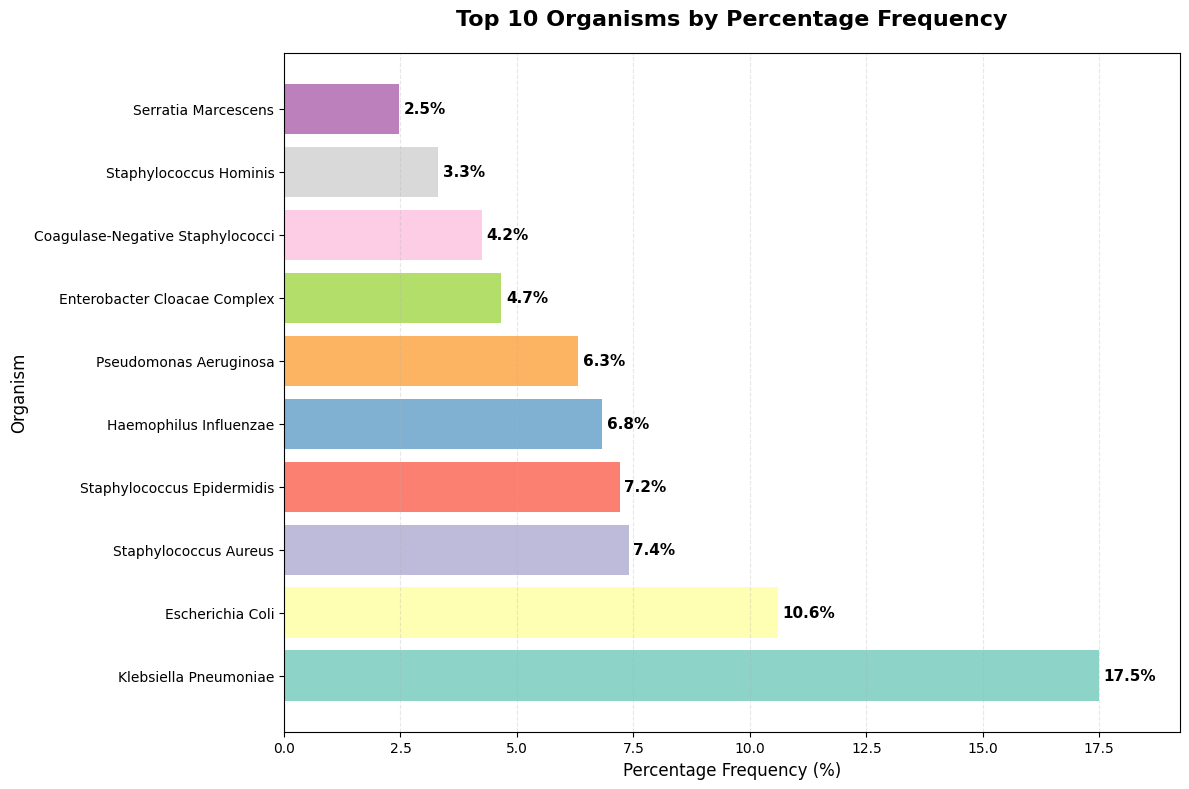


📊 Top 10 Organisms by Percentage Frequency:
Rank  Organism                                 Count      Percentage  
1     Klebsiella Pneumoniae                    2993       17.5%
2     Escherichia Coli                         1814       10.6%
3     Staphylococcus Aureus                    1266       7.4%
4     Staphylococcus Epidermidis               1233       7.2%
5     Haemophilus Influenzae                   1169       6.8%
6     Pseudomonas Aeruginosa                   1080       6.3%
7     Enterobacter Cloacae Complex             799        4.7%
8     Coagulase-Negative Staphylococci         726        4.2%
9     Staphylococcus Hominis                   566        3.3%
10    Serratia Marcescens                      423        2.5%
TOTAL All organisms                            17118      100.0%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set style for better visuals
plt.style.use('default')

# Get organism counts and calculate percentages
organism_counts = df['organism'].value_counts()
total_organisms = organism_counts.sum()
organism_percentages = (organism_counts / total_organisms) * 100

# Get top 10 organisms by percentage
top_10 = organism_percentages.head(10)

# Create the horizontal bar plot (cleaner for names)
plt.figure(figsize=(12, 8))
bars = plt.barh(top_10.index, top_10.values, color=plt.cm.Set3(np.arange(len(top_10))))

# Customize the plot
plt.title('Top 10 Organisms by Percentage Frequency', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Percentage Frequency (%)', fontsize=12)
plt.ylabel('Organism', fontsize=12)
plt.xlim(0, max(top_10.values) * 1.1)  # Add some padding

# Add percentage labels to the right of bars
for i, percentage in enumerate(top_10.values):
    plt.text(percentage + 0.1, i, f'{percentage:.1f}%',
             va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.show()

# Show the exact percentages in table format
print("\n📊 Top 10 Organisms by Percentage Frequency:")
print("=" * 65)
print(f"{'Rank':<5} {'Organism':<40} {'Count':<10} {'Percentage':<12}")
print("=" * 65)

for rank, (organism, percentage) in enumerate(top_10.items(), 1):
    count = organism_counts[organism]
    print(f"{rank:<5} {organism:<40} {count:<10} {percentage:.1f}%")

print("=" * 65)
print(f"{'TOTAL':<5} {'All organisms':<40} {total_organisms:<10} 100.0%")
print("=" * 65)

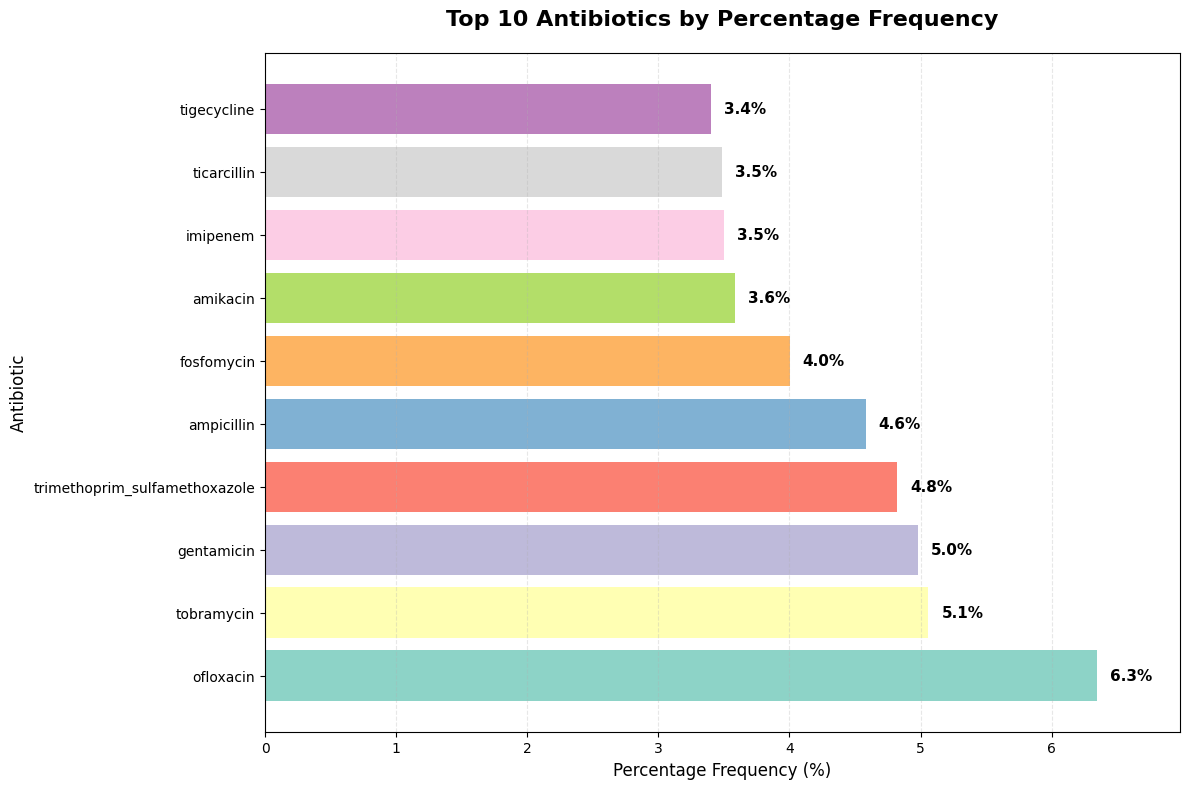


📊 Top 10 Antibiotics by Percentage Frequency:
Rank  Antibiotic                               Count      Percentage  
1     ofloxacin                                1086       6.3%
2     tobramycin                               866        5.1%
3     gentamicin                               852        5.0%
4     trimethoprim_sulfamethoxazole            825        4.8%
5     ampicillin                               784        4.6%
6     fosfomycin                               685        4.0%
7     amikacin                                 614        3.6%
8     imipenem                                 599        3.5%
9     ticarcillin                              596        3.5%
10    tigecycline                              582        3.4%
TOTAL All antibiotics                          17118      100.0%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set style for better visuals
plt.style.use('default')

# Get antibiotic counts and calculate percentages
antibiotic_counts = df['antibiotic_canon'].value_counts()  # Use canonical names if available
total_antibiotics = antibiotic_counts.sum()
antibiotic_percentages = (antibiotic_counts / total_antibiotics) * 100

# Get top 10 antibiotics by percentage
top_10_abx = antibiotic_percentages.head(10)

# Create the horizontal bar plot
plt.figure(figsize=(12, 8))
bars = plt.barh(top_10_abx.index, top_10_abx.values, color=plt.cm.Set3(np.arange(len(top_10_abx))))

# Customize the plot
plt.title('Top 10 Antibiotics by Percentage Frequency', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Percentage Frequency (%)', fontsize=12)
plt.ylabel('Antibiotic', fontsize=12)
plt.xlim(0, max(top_10_abx.values) * 1.1)  # Add some padding

# Add percentage labels to the right of bars
for i, percentage in enumerate(top_10_abx.values):
    plt.text(percentage + 0.1, i, f'{percentage:.1f}%',
             va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.show()

# Show the exact percentages in table format
print("\n📊 Top 10 Antibiotics by Percentage Frequency:")
print("=" * 65)
print(f"{'Rank':<5} {'Antibiotic':<40} {'Count':<10} {'Percentage':<12}")
print("=" * 65)

for rank, (antibiotic, percentage) in enumerate(top_10_abx.items(), 1):
    count = antibiotic_counts[antibiotic]
    print(f"{rank:<5} {antibiotic:<40} {count:<10} {percentage:.1f}%")

print("=" * 65)
print(f"{'TOTAL':<5} {'All antibiotics':<40} {total_antibiotics:<10} 100.0%")
print("=" * 65)

In [ ]:
#display unique antibiotics
print(df['antibiotic_canon'].unique())

['ampicillin' 'chloramphenicol' 'clindamycin' 'erythromycin' 'gentamicin'
 'linezolid' 'streptomycin' 'teicoplanin' 'tigecycline' 'vancomycin'
 'amikacin' 'amoxicillin' 'aztreonam' 'cefepime' 'cefotaxime' 'ertapenem'
 'fosfomycin' 'imipenem' 'mecillinam' 'nalidixic_acid' 'netilmicin'
 'ofloxacin' 'piperacillin' 'ticarcillin' 'tobramycin'
 'trimethoprim_sulfamethoxazole' 'cefoxitin' 'fusidic_acid' 'kanamycin'
 'minocycline' 'penicillin_g' 'tetracycline' 'ceftazidime' 'meropenem'
 'norfloxacin' 'oxacillin' 'pristinamycin' 'telithromycin' 'cefixime'
 'temocillin' 'colistin' 'cephalexin' 'nitrofurantoin']
